In [1]:
%load_ext autoreload

import pandas as pd, numpy as np, matplotlib.pyplot as plt

from sklearn import set_config
from sklearn.preprocessing import OneHotEncoder

import time
from tqdm import tqdm
from datetime import datetime

import torch
from torch import nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.nn.init as init

from feature_engineering import replace_abnormal, add_features
from datasets import ObsDataset, TestDataset, get_dataloaders, random_split, random_k_fold
from models import biLSTMClassifier, biGRUClassifier
from utils import get_device, init_rnn, EarlyStopper

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None

/home/hugocth/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import dataset

raw_train_data = pd.read_csv("data/X_train_N1UvY30.csv")
raw_target_data = pd.read_csv("data/y_train_or6m3Ta.csv")
raw_test_data = pd.read_csv("data/X_test_m4HAPAP.csv")

In [3]:
train_data = add_features(replace_abnormal(raw_train_data))

Replaced 41 abnormal observations.
Feature engineering completed: 22 features.


In [4]:
train_data[1]

['price',
 'bid',
 'ask',
 'log_bid_size',
 'log_ask_size',
 'sizes_imb',
 'sym_log_flux',
 'bid_price_imb',
 'ask_price_imb',
 'ask_bid_imb',
 'ask_bid_price_imb2',
 'venue_0',
 'venue_1',
 'venue_2',
 'venue_3',
 'venue_4',
 'venue_5',
 'action_A',
 'action_D',
 'action_U',
 'trade_False',
 'trade_True']

In [5]:
imbs = ["sizes_imb", "bid_price_imb", "ask_price_imb", "ask_bid_imb", "ask_bid_price_imb2"] 
val=0.00001
for imb in imbs:
    print(f"{imb}", len(train_data[0].query(f"0 < {imb} < @val | @val < {imb} < 0")[imb]))

sizes_imb 0
bid_price_imb 1201
ask_price_imb 1018
ask_bid_imb 8574
ask_bid_price_imb2 118646


In [8]:
train_data[0]

,price,bid,ask,log_bid_size,log_ask_size,sizes_imb,sym_log_flux,bid_price_imb,ask_price_imb,ask_bid_imb,...,venue_1,venue_2,venue_3,venue_4,venue_5,action_A,action_D,action_U,trade_False,trade_True
0,0.30,0.00,0.01,4.615121,0.693147,0.980198,5.298317,-0.761594,-0.733140,0.761594,...,0,0,0,1,0,1,0,0,1,0
1,-0.17,0.00,0.01,4.615121,0.693147,0.980198,5.298317,-0.761594,-0.810930,0.761594,...,0,0,0,1,0,1,0,0,1,0
2,0.28,0.00,0.01,4.615121,0.693147,0.980198,-5.298317,-0.761594,-0.731076,0.761594,...,0,0,0,1,0,0,1,0,1,0
3,0.30,0.00,0.01,4.615121,0.693147,0.980198,5.298317,-0.761594,-0.733140,0.761594,...,0,0,0,1,0,1,0,0,1,0
4,0.37,0.00,0.01,4.615121,0.693147,0.980198,-5.298317,-0.761594,-0.738589,0.761594,...,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16079995,1.32,0.01,0.06,6.601230,5.568345,0.475904,-5.298317,-0.755206,-0.722590,0.613357,...,0,0,0,1,0,0,1,0,1,0
16079996,0.06,0.01,0.06,6.601230,5.891644,0.341241,5.298317,-0.613357,0.000000,0.613357,...,0,0,0,0,0,1,0,0,1,0
16079997,1.26,0.01,0.06,6.601230,5.891644,0.341241,5.298317,-0.754901,-0.720696,0.613357,...,0,0,0,1,0,1,0,0,1,0
16079998,1.26,0.01,0.06,6.601230,5.891644,0.341241,5.298317,-0.754901,-0.720696,0.613357,...,0,0,0,1,0,1,0,0,1,0


In [9]:
train_data[0][["log_bid_size", "log_ask_size"]].describe().T

,count,mean,std,min,25%,50%,75%,max
log_bid_size,16080000.0,5.146432,1.685838,0.693147,4.615121,5.411646,6.218600,11.381267
log_ask_size,16080000.0,5.144206,1.681362,0.693147,4.615121,5.402677,6.216606,11.919164


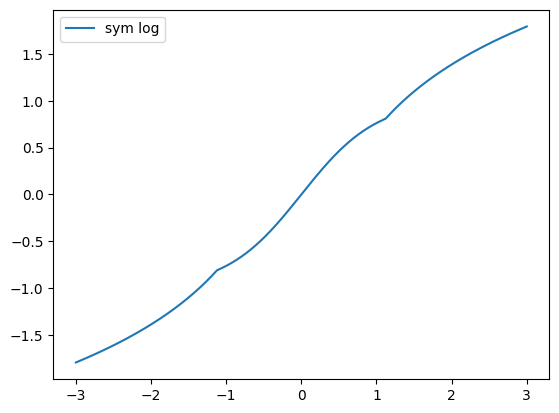

In [10]:
def symmetric_log(arr):
    "Returns a sign-preserving log for large values, tanh for values near 0"
    old_settings = np.seterr(divide='raise', invalid='raise')
    try:
        # Temporarily set settings to ignore invalid values and divide by zero warnings
        with np.errstate(divide='ignore', invalid='ignore'):
            result_pos = np.maximum(np.log(arr*2), np.tanh(arr))
            result_neg = np.maximum(np.log(-arr*2), -np.tanh(arr))
    finally:
        # Restore the original error handling settings
        np.seterr(**old_settings)
    result_pos[np.isinf(result_pos) | np.isnan(result_pos)] = 0
    result_neg[np.isinf(result_neg) | np.isnan(result_neg)] = 0
    return result_pos - result_neg

def symmetric_lorentzian(arr, n=1.7):
    "Returns the lorentzian(x) if positive, -lorentzian(x) if negative"
    res = arr.copy()
    res[np.where(res>0)], res[np.where(res<0)] = np.log(1+0.5*(res[np.where(res>0)]/15)**n), -np.log(1+0.5*(-res[np.where(res<0)]/15)**n)
    return res

N=3
x = np.linspace(-N,N,10000)
y_sym_log = symmetric_log(x)
y_sym_lorentz = symmetric_lorentzian(x)
y_sym_lorentz_1 = symmetric_lorentzian(x, n=1)
plt.plot(x,y_sym_log, label="sym log")
# plt.plot(x,y_sym_lorentz, label="sym lorentz 2")
# plt.plot(x,y_sym_lorentz_1, label="sym lorentz 1")
# plt.plot(x,np.tanh(x), label="tanh")
plt.legend()
plt.show()